<a href="https://colab.research.google.com/github/ysai258/Face-Mask-Detection/blob/main/Mask_dect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Drive**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Model creation**

In [13]:
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np
import os
 
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
 
imagePaths = list(paths.list_images('/content/drive/My Drive/face-mask-detector/Dataset'))
print(len(imagePaths))
data = []
labels = []
 
for imagePath in imagePaths:

    label = imagePath.split(os.path.sep)[-2]
 
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
 
    data.append(image)
    labels.append(label)
print("\ndata labels done\n")
data = np.array(data, dtype="float32")
labels = np.array(labels)
 

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
 
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

print("\ntrain-test-split done\n")

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

 
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3))) 
 
x = baseModel.output
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(2, activation="softmax")(x)
 
model = Model(inputs=baseModel.input, outputs=x)
 
for layer in baseModel.layers:
    layer.trainable = False

print("\nmodel compile\n")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)


model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 
result = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

print("\nmodel fit done\n")
 
predIdxs = model.predict(testX, batch_size=BS)
 
predIdxs = np.argmax(predIdxs, axis=1)
 
print(classification_report(testY.argmax(axis=1),predIdxs,target_names=lb.classes_))

1376

data labels done


train-test-split done

9412608/9406464 [==============================] - 0s 0us/step

model compile

Epoch 1/20
34/34 [==============================] - 57s 2s/step - loss: 0.6625 - accuracy: 0.7004 - val_loss: 0.2461 - val_accuracy: 0.9674
Epoch 2/20
34/34 [==============================] - 54s 2s/step - loss: 0.2501 - accuracy: 0.9553 - val_loss: 0.1219 - val_accuracy: 0.9819
Epoch 3/20
34/34 [==============================] - 54s 2s/step - loss: 0.1381 - accuracy: 0.9782 - val_loss: 0.0731 - val_accuracy: 0.9891
Epoch 4/20
34/34 [==============================] - 55s 2s/step - loss: 0.0903 - accuracy: 0.9839 - val_loss: 0.0537 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 57s 2s/step - loss: 0.0678 - accuracy: 0.9876 - val_loss: 0.0447 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 56s 2s/step - loss: 0.0669 - accuracy: 0.9838 - val_loss: 0.0335 - val_accuracy: 0.9964
Epoch 7/20
34/34 [===============

In [14]:
import cv2
from google.colab.patches import cv2_imshow 
 
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/face-mask-detector/haarcascade_frontalface_default.xml')
 
def mask_detect(img_Path):
  img = cv2.imread(img_Path)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray)
  flag = 0
  for (x,y,w,h) in faces:
    roi = img[y:+y+h , x:x+w]
    cv2.imwrite('1.jpg',roi)
    image = load_img('1.jpg',target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)
    image= np.expand_dims(image, axis=0)
    preds = model.predict(image)
    mask,No_mask = preds[0]
    if mask > No_mask:
      label = "MASK"
      color = (0,255,0)
    else:
      label = "NO MASK"
      color = (0,0,255)
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    cv2.putText(img,label,(x,y-20),cv2.FONT_HERSHEY_SIMPLEX,0.38,color,2)
    flag = 1
  if(flag == 0):
    cv2.putText(img,"No Face",(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),1)
  cv2_imshow(img)

**Accessing each image in examples folder and applying face mask detection**

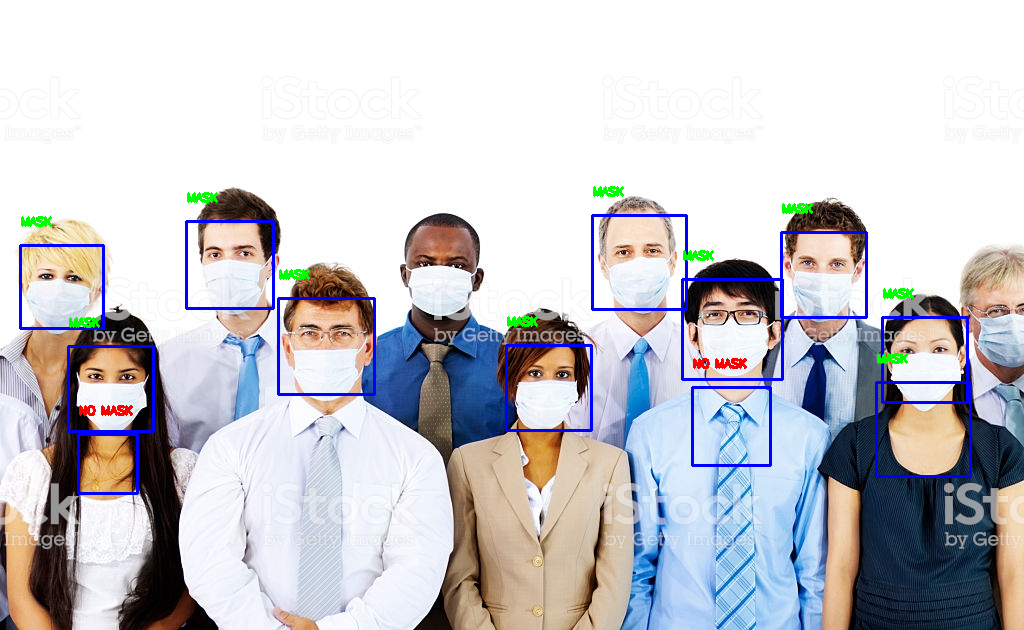

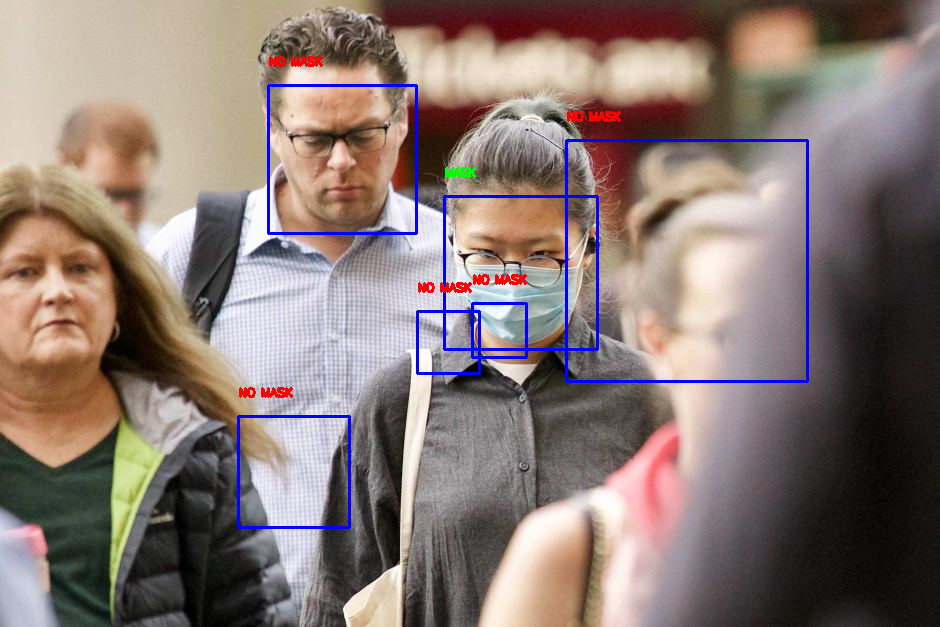

In [ ]:
from imutils import paths
files = list(paths.list_images('/content/drive/My Drive/face-mask-detector/examples'))
for img in files:
  mask_detect(img)

**Applying on live web cam photo**

<IPython.core.display.Javascript object>

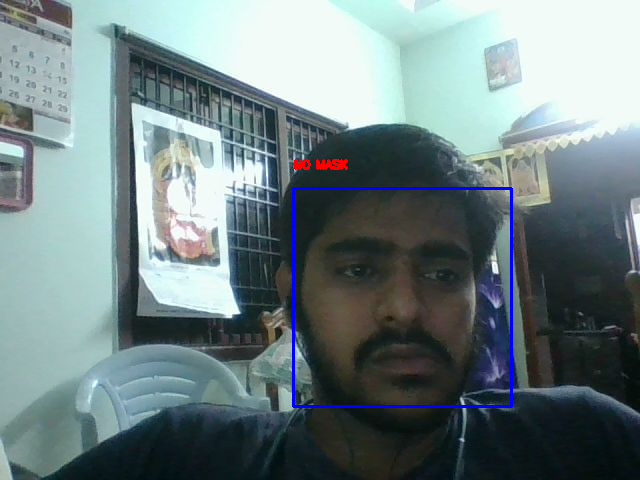

In [16]:
mask_detect(take_photo())

**Code snippet for accessing webcam**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
 
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
 
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
 
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
 
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
 
      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
 
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;  
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))